In [ ]:
def build_vocab(file_path):
    words = set()
    tags = set()
    with open(file_path) as file:
        for line in file:
            line = line.split()
            if line:
                words.add(line[0])
                tags.add(line[1])
    tags.add('PAD_TAG')
    return {'words': words, 'tags': tags}

In [ ]:
vocab = build_vocab('pos/train.txt')

In [ ]:
def get_idx_map(vocab):
    word2idx = {}
    for i, word in enumerate(vocab['words']):
        word2idx[word] = i
    idx2word = {idx: word for word, idx in word2idx.items()}

    tag2idx = {}
    for i, tag in enumerate(vocab['tags']):
        tag2idx[tag] = i
    idx2tag = {idx: tag for tag, idx in tag2idx.items()}
    return word2idx, tag2idx, idx2word, idx2tag

In [ ]:
word2idx, tag2idx, idx2word, idx2tag = get_idx_map(vocab)
tagset_size = len(tag2idx)

In [ ]:
def load_data(file_path):
    sentences = []
    labels = []
    with open(file_path) as file:
        words = []
        tags = []
        for line in file:
            line = line.split()
            if not line and words:
                sentences.append(words)
                labels.append(tags)
                words = []
                tags = []
            else:
                words.append(line[0])
                tags.append(line[1])
    return {'sentences': sentences, 'labels': labels}

In [ ]:
train_data = load_data('pos/train.txt')
valid_data = load_data('pos/valid.txt')
test_data = load_data('pos/test.txt')

In [ ]:
def encode_sentence(sentence, tokenizer):
    input_ids = []
    token_start_pos = []
    for token in sentence:
        token_start_pos.append(len(input_ids))
        input_ids += tokenizer.tokenize(token)
    input_ids = tokenizer.convert_tokens_to_ids(input_ids)
    return input_ids, token_start_pos

In [ ]:
def batch_encode_sentences(batch_sentences, tokenizer):
    batch_input_ids = []
    batch_token_start_pos = []
    for sentence in batch_sentences:
        input_ids, token_start_pos = encode_sentence(sentence, tokenizer)
        batch_input_ids.append(input_ids)
        batch_token_start_pos.append(token_start_pos)
    return batch_input_ids, batch_token_start_pos

In [ ]:
from numpy import random
import torch

def get_data_loader(sentences, labels, tokenizer, batch_size, shuffle=False, random_seed=0):
    indices = list(range(len(labels)))
    if shuffle:
        random.seed(random_seed)
        random.shuffle(indices)
    for i in range((len(indices) - 1) // batch_size + 1):
        batch_sentences = [sentences[idx] for idx in indices[i*batch_size:(i+1)*batch_size]]
        batch_labels = [labels[idx] for idx in indices[i*batch_size:(i+1)*batch_size]]
        batch_input_ids, batch_token_start_pos = batch_encode_sentences(batch_sentences, tokenizer)

        max_ids_len = max([len(input_ids) for input_ids in batch_input_ids])
        max_sentence_len = max([len(sentence) for sentence in batch_sentences])

        batch_modified_labels = []
        batch_masks = []
        for i in range(len(batch_sentences)):
            input_ids = batch_input_ids[i]

            attention_mask = [1]*len(input_ids) + [0]*(max_ids_len-len(input_ids))
            batch_masks.append(attention_mask)

            token_start_pos = batch_token_start_pos[i]
            input_ids += [0]*(max_ids_len-len(input_ids))

            modified_labels = [-1]*max_ids_len
            for j in range(len(token_start_pos)):
                modified_labels[token_start_pos[j]] = tag2idx[batch_labels[i][j]]       
            batch_modified_labels.append(modified_labels)
                
        batch_input_ids = torch.LongTensor(batch_input_ids) 
        batch_modified_labels = torch.LongTensor(batch_modified_labels)
        batch_masks = torch.LongTensor(batch_masks)
        
        yield batch_input_ids, batch_modified_labels, batch_masks 

In [ ]:
from transformers import BertForTokenClassification
from transformers import AdamW
import logging
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=tagset_size).cuda()

In [ ]:
import numpy as np

def accuracy(outputs, labels):
    mask = (labels >= 0)
    n_tokens = int(np.sum(mask))
    
    return np.sum(labels == np.argmax(outputs, axis=1)) / n_tokens

In [ ]:
from tqdm.auto import tqdm

def train(model, criterion, accuracy, optimizer, scheduler, data_loader, data_len, mixed_precision=False, scaler=None):
    model.train()
    train_loss, train_acc = float('inf'), 0.
    losses, accuracies = [], []
    tqdm_iterator = tqdm(enumerate(data_loader), total=data_len, leave=False, disable=True)
    summary_every = data_len//10
    for i, data in tqdm_iterator:
        input_ids = data[0].cuda()
        attention_mask = data[2].cuda()
        labels = data[1].cuda()

        if mixed_precision:
            with torch.cuda.amp.autocast():
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs[0].view(-1, outputs[0].shape[-1]), labels.view(-1))

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            # this if condition is added to prevent "UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`."
            if optimizer._step_count >= 1:
                scheduler.step()
        else:
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs[0].view(-1, outputs[0].shape[-1]), labels.view(-1))
            optimizer.zero_grad()
            loss.backward()   
            optimizer.step()
            scheduler.step()

        losses.append(loss.item())
        outputs, labels = outputs[0].view(-1, outputs[0].shape[-1]).data.cpu().numpy(), labels.data.cpu().numpy()
        acc = accuracy(outputs, labels.flatten())
        accuracies.append(acc)
        
        if i % summary_every == 0:
            train_loss = float(np.mean(losses))
            train_acc = float(np.mean(accuracies))
            tqdm_iterator.set_postfix(loss='{:.4f}'.format(train_loss), acc='{:.4f}'.format(train_acc))
            losses = []
            accuraies = []
    return float(train_loss), float(train_acc)

In [ ]:
def evaluate(model, criterion, accuracy, data_loader, data_len):
    model.eval()
    losses, accuracies = [], []
    tqdm_iterator = tqdm(enumerate(data_loader), total=data_len, leave=False, disable=True)
    with torch.no_grad():
        for i, data in tqdm_iterator:
            input_ids = data[0].cuda()
            attention_mask = data[2].cuda()
            labels = data[1].cuda()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs[0].view(-1, outputs[0].shape[-1]), labels.view(-1))
            outputs, labels = outputs[0].view(-1, outputs[0].shape[-1]).data.cpu().numpy(), labels.data.cpu().numpy()
            acc = accuracy(outputs, labels.flatten())
            losses.append(loss.item())
            accuracies.append(acc)
    eval_loss = np.mean(losses)
    eval_acc = np.mean(accuracies)
    
    return float(eval_loss), float(eval_acc)

In [ ]:
from transformers import get_linear_schedule_with_warmup

def train_and_evaluate(model, criterion, accuracy, optimizer,
                       train_data, val_data, tokenizer, batch_size, n_epochs, mixed_precision=False):
    best_eval_loss = float('inf')
    best_epochs = 0
    summary = {'train': {'loss': [], 'acc': []}, 
               'val': {'loss': [], 'acc': []}}
    print('start training: ')
    train_data_len = (len(train_data['sentences']) - 1) // batch_size + 1
    eval_data_len = (len(valid_data['sentences']) - 1) // batch_size + 1
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, 
                                                num_training_steps=train_data_len*n_epochs)
    scaler = None
    if mixed_precision:
        scaler = torch.cuda.amp.GradScaler()
    for i in range(1, n_epochs + 1):
        print('-'*50)
        print('epoch ', i, ':')
        train_data_loader = get_data_loader(train_data['sentences'], train_data['labels'], tokenizer, batch_size)
        train_loss, train_acc = train(model, criterion, accuracy, optimizer, scheduler, train_data_loader, train_data_len, mixed_precision, scaler)
        summary['train']['loss'].append(train_loss)
        summary['train']['acc'].append(train_acc)
        print('train loss: {:.4f}; train acc: {:.4f}'.format(train_loss, train_acc))
        
        eval_data_loader = get_data_loader(valid_data['sentences'], valid_data['labels'], tokenizer, batch_size)
        eval_loss, eval_acc = evaluate(model, criterion, accuracy, eval_data_loader, eval_data_len)
        if eval_loss < best_eval_loss:
            best_eval_loss = eval_loss
            best_epochs = i
        summary['val']['loss'].append(eval_loss)
        summary['val']['acc'].append(eval_acc)
        print('eval loss: {:.4f}; eval acc: {:.4f}'.format(eval_loss, eval_acc))
    print('-'*50)
    print('finish training.')
    
    summary['best_eval_loss'] = best_eval_loss
    summary['best_epochs'] = best_epochs
        
    return summary

In [ ]:
from torch import nn
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=tagset_size).cuda()
criterion = nn.CrossEntropyLoss(ignore_index = -1)
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)

In [ ]:
batch_size = 64
n_epochs = 7

In [ ]:
summary = train_and_evaluate(model, criterion, accuracy, optimizer, train_data, valid_data, tokenizer, batch_size, n_epochs, mixed_precision=True)

start training: 
--------------------------------------------------
epoch  1 :
train loss: 0.4983; train acc: 0.6789
eval loss: 0.4157; eval acc: 0.9045
--------------------------------------------------
epoch  2 :
train loss: 0.2861; train acc: 0.9173
eval loss: 0.2800; eval acc: 0.9307
--------------------------------------------------
epoch  3 :
train loss: 0.2257; train acc: 0.9383
eval loss: 0.2510; eval acc: 0.9361
--------------------------------------------------
epoch  4 :
train loss: 0.1920; train acc: 0.9479
eval loss: 0.2387; eval acc: 0.9385
--------------------------------------------------
epoch  5 :
train loss: 0.1745; train acc: 0.9526
eval loss: 0.2308; eval acc: 0.9414
--------------------------------------------------
epoch  6 :
train loss: 0.1576; train acc: 0.9582
eval loss: 0.2268; eval acc: 0.9420
--------------------------------------------------
epoch  7 :
train loss: 0.1509; train acc: 0.9611
eval loss: 0.2269; eval acc: 0.9430
-------------------------------

In [ ]:
import matplotlib.pyplot as plt

def plot_summary(summary):
    data_len = len(summary['train']['loss'])

    plt.figure(figsize=(15,5))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    plt.subplot(121)
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.plot(np.arange(1, data_len+1), summary['train']['loss'],  label='train')
    plt.plot(np.arange(1, data_len+1), summary['val']['loss'], label='val')
    plt.legend()
    plt.xlabel('number of epochs', fontsize=12)
    plt.ylabel('loss', fontsize=12)

    plt.subplot(122)
    plt.plot(np.arange(1, data_len+1), summary['train']['acc'],  label='train')
    plt.plot(np.arange(1, data_len+1), summary['val']['acc'], label='val')
    plt.legend()
    plt.xlabel('number of epochs', fontsize=12)
    plt.ylabel('acc', fontsize=12)

    plt.show()

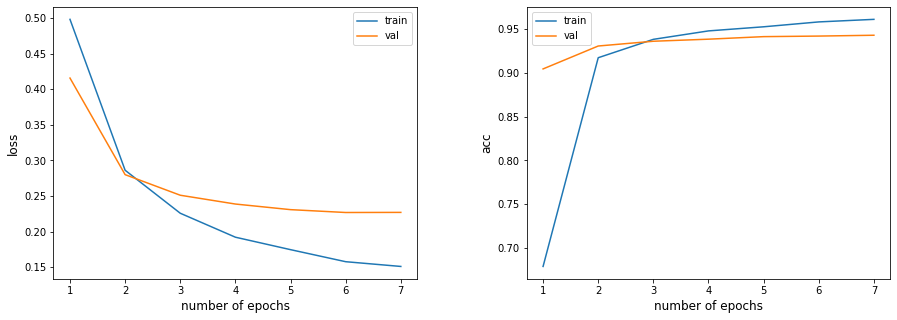

In [ ]:
plot_summary(summary)

In [ ]:
def test(model, criterion, accuracy, test_data, tokenizer, batch_size):
    test_data_loader = get_data_loader(test_data['sentences'], test_data['labels'], tokenizer, batch_size)
    test_data_len = (len(test_data['sentences']) - 1) // batch_size + 1
    test_loss, test_acc = evaluate(model, criterion, accuracy, test_data_loader, test_data_len)

    print('test loss: {:.4f}; test acc: {:.4f}'.format(test_loss, test_acc))

In [ ]:
test(model, criterion, accuracy, test_data, tokenizer, batch_size)

test loss: 0.2661; test acc: 0.9348
